In [33]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats,integrate
import pandas as pd
import seaborn as sns
from scipy import linalg as la

1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


In [34]:
#Generate a dataset with 3 features 

x_1 = np.random.normal(0, 1, 1000)
x_2 = np.random.normal(0, 3, 1000) + x_1
x_3 = (2*x_1)+x_2
d_s_3 = np.array([x_1,x_2,x_3])


In [35]:
#Find the eigenvectors and eigenvalues of the covariance matrix 

l, V = la.eig(np.cov(d_s_3))
print ("eigenvalues of the covariance matrix:\n",np.real_if_close(l),"\n")
print ("eigenvectors of the covariance matrix:\n",V)


eigenvalues of the covariance matrix:
 [2.81648234e+01 4.15286114e-16 1.89732605e+00] 

eigenvectors of the covariance matrix:
 [[-0.1189301  -0.81649658  0.56496811]
 [-0.5730117  -0.40824829 -0.71062714]
 [-0.81087189  0.40824829  0.41930909]]


In [36]:
#Find the eigenvectors and eigenvalues using SVD.

U, spectrum, Vt = la.svd(d_s_3)

#The non-zero elements of D (non-zero singular values) are the square roots of 
#the non-zero eigenvalues of  𝐴𝑇𝐴  or  𝐴𝐴𝑇 (the covariance matrix).
print ("eigenvalues of the covariance matrix from SVD:\n",(spectrum**2)/(1000-1),'\n')

#The columns of U (left-singular vectors) are eigenvectors of  𝐴𝐴𝑇 (the covariance matrix)
print ("eigenvectors of the covariance matrix:\n",U/(1000-1),"\n")


#Check that the two procedures yield to same result
D = np.zeros((3, 3))
for i in range(min(3, 3)):
    D[i, i] = (spectrum[i]**2)/(1000-1)
    
cov_SVD = (np.dot(U, np.dot(D, (la.inv(U)))))
print("The covariance matrix biuld with parametrs SVD:\n",cov_SVD,"\n")
print("The original covariance matrix:\n ",np.cov(d_s_3),"\n")
print("are they sam?",np.allclose(cov_SVD, np.cov(d_s_3),rtol=1e-2))



eigenvalues of the covariance matrix from SVD:
 [2.81659318e+01 1.89738418e+00 5.92402706e-32] 

eigenvectors of the covariance matrix:
 [[-0.00011905  0.00056553 -0.00081731]
 [-0.00057358 -0.00071134 -0.00040866]
 [-0.00081169  0.00041972  0.00040866]] 

The covariance matrix biuld with parametrs SVD:
 [[ 1.0040475   1.15775715  3.16585215]
 [ 1.15775715 10.20602494 12.52153924]
 [ 3.16585215 12.52153924 18.85324354]] 

The original covariance matrix:
  [[ 1.00397916  1.15764423  3.16560254]
 [ 1.15764423 10.20583836 12.52112681]
 [ 3.16560254 12.52112681 18.85233189]] 

are they sam? True


In [37]:
#What percent of the total dataset's variability ....

Lambda=np.diag(np.real_if_close(spectrum))
print (Lambda,"\n")
print ("percent of the x1:",(Lambda[0,0]/Lambda.trace())*100)
print ("percent of the x2:",(Lambda[1,1]/Lambda.trace())*100)
print ("percent of the x3:",(Lambda[2,2]/Lambda.trace())*100,"\n")

# we can see that the two first components are enough to 99% and it is clear becuase the 3th 
# is the combenition of other and does not have new information.

[[1.67743154e+02 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.35371886e+01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 7.69292079e-15]] 

percent of the x1: 79.39363975455323
percent of the x2: 20.606360245446755
percent of the x3: 3.641096318360842e-15 



In [38]:
#Redefine the data in the basis yielded by the PCA procedure
d_s_3_n =  np.dot(V.T, d_s_3)

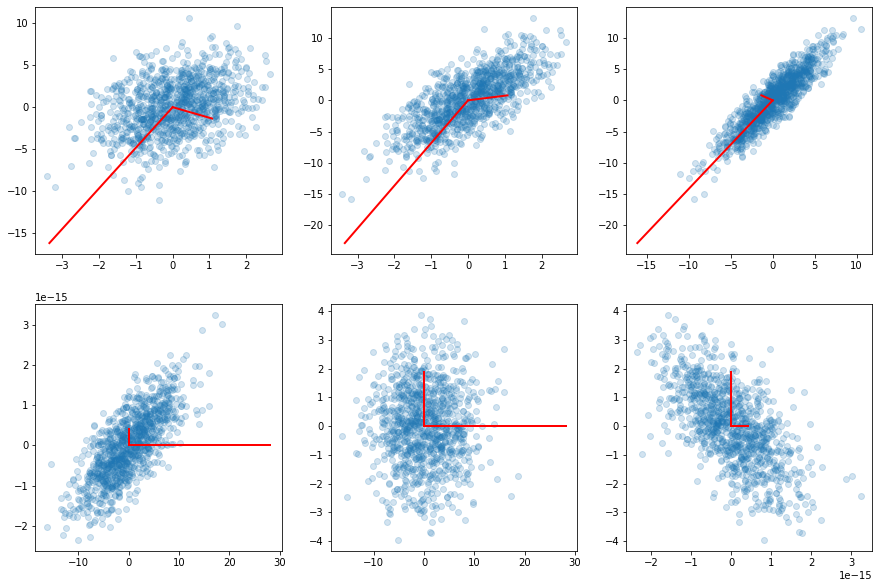

In [39]:
#Plot the data points in the original and the new coordiantes.....

fig = plt.figure(figsize = (15,10))

plt.subplot(2,3,1)
plt.scatter(d_s_3[0,:], d_s_3[1,:], alpha=0.2)
for li, vi in zip(l, V.T):
    plt.plot([0, li*vi[0]], [0, li*vi[1]], 'r-', lw=2)

plt.subplot(2,3,2)    
plt.scatter(d_s_3[0,:], d_s_3[2,:], alpha=0.2)
for li, vi in zip(l, V.T):
    plt.plot([0, li*vi[0]], [0, li*vi[2]], 'r-', lw=2)

plt.subplot(2,3,3)    
plt.scatter(d_s_3[1,:], d_s_3[2,:], alpha=0.2)
for li, vi in zip(l, V.T):
    plt.plot([0, li*vi[1]], [0, li*vi[2]], 'r-', lw=2)  
    
plt.subplot(2,3,4)
plt.scatter(d_s_3_n[0,:], d_s_3_n[1,:], alpha=0.2)
for li, vi in zip(l, np.diag([1]*3)):
    plt.plot([0, li*vi[0]], [0, li*vi[1]], 'r-', lw=2)

plt.subplot(2,3,5)
plt.scatter(d_s_3_n[0,:], d_s_3_n[2,:], alpha=0.2)
for li, vi in zip(l, np.diag([1]*3)):
    plt.plot([0, li*vi[0]], [0, li*vi[2]], 'r-', lw=2)

plt.subplot(2,3,6)
plt.scatter(d_s_3_n[1,:], d_s_3_n[2,:], alpha=0.2)
for li, vi in zip(l, np.diag([1]*3)):
    plt.plot([0, li*vi[1]], [0, li*vi[2]], 'r-', lw=2)    

2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

In [47]:
new=[x_1,x_2,x_3]
for i in range(10):
    x=np.random.normal(0, i*(1/50), 1000)
    new.append(x)    
new=np.array(new)     

#U_n, spectrum_n, Vt_n = la.svd(new)
spectrum_n, V = la.eig(np.cov(new))
Lambda_n=np.diag(np.real_if_close(spectrum_n))
for i in range(13):
    print ("percent of the x",str(i), ":",(Lambda_n[i,i]/Lambda_n.trace())*100)


percent of the x 0 : 93.33307675563172
percent of the x 1 : 6.2876523923501075
percent of the x 2 : 0.10697110593468209
percent of the x 3 : 0.08604629757586947
percent of the x 4 : 0.06311542355871869
percent of the x 5 : 0.04946406741192217
percent of the x 6 : 0.03359612712946418
percent of the x 7 : 0.02087430605080677
percent of the x 8 : 0.012850896626894447
percent of the x 9 : 3.250370798386041e-15
percent of the x 10 : 0.005084922029359794
percent of the x 11 : 0.0012677057004331811
percent of the x 12 : 0.0


3 \. **Looking at an oscillating spring** (optional)

Imagine you have $n$ cameras looking at a spring oscillating along the $x$ axis. Each  camera record the motion of the spring looking at it along a given direction defined by the pair $(\theta_i, \phi_i)$, the angles in spherical coordinates. 

Start from the simulation of the records (say ${\cal O}(1000)$) of the spring's motion along the x axis, assuming a little random noise affects the measurements along the $y$. Rotate such dataset to emulate the records of each camera.

Perform a Principal Component Analysis on the thus obtained dataset, aiming at finding the only one coordinate that really matters.


4\. **PCA on the MAGIC dataset** (optional)

Perform a PCA on the magic04.data dataset

In [ ]:
# get the dataset and its description on the proper data directory
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P ~/data/
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P ~/data/ 